In [1]:
from tqdm.auto import tqdm
import multiprocessing
import sys
from datetime import datetime
from time import sleep
import datetime as dt
import pandas as pd

from Pandora.helper import TDays
from Pandora.research.backtest import CODES_SHORT, calc_sharpe, COMMISSION
from vnpy.app.vnpy_portfoliostrategy.strategies.macd_bband_strategy import MACDBBANDStrategy
from vnpy.trader.constant import Interval, Product
from vnpy.trader.optimize import OptimizationSetting
from vnpy.trader.setting import SETTINGS
from logging import INFO
from vnpy.app.vnpy_portfoliostrategy import BacktestingEngine

SETTINGS["log.active"] = True
SETTINGS["log.level"] = INFO
SETTINGS["log.console"] = True



In [2]:
def get_mc(codes):
    from vnpy.trader.database import get_database

    database = get_database()
    today = datetime.combine(TDays.get_tday(fmt=None), dt.time(0))
    contracts = database.load_contract_data(product=Product.FUTURES, start=today, end=today)
    mc = [i for i in contracts if i.symbol.endswith('00') and i.product_id in codes]

    return mc


In [3]:
mc = get_mc(CODES_SHORT)


In [4]:
engine = BacktestingEngine()
engine.contracts = {i.vt_symbol: i for i in mc}

engine.set_parameters(
    vt_symbols=[i.vt_symbol for i in mc],
    interval=Interval.MINUTE_15,
    start=datetime(2015, 1, 1),
    end=datetime(2024, 6, 27),
    rates={
        i.vt_symbol: COMMISSION for i in mc
    },
    slippages={
        i.vt_symbol: 0 for i in mc
    },
    sizes={
        i.vt_symbol: i.size for i in mc
    },
    priceticks={
        i.vt_symbol: i.pricetick for i in mc
    },
    capital=1e8,
)

engine.load_data()



2024-06-28 13:55:03.047542	开始加载历史数据
2024-06-28 13:55:03.847908	AP00.CZCE历史数据加载完成，数据量：23655
2024-06-28 13:55:04.096750	CJ00.CZCE历史数据加载完成，数据量：18750
2024-06-28 13:55:04.681690	FG00.CZCE历史数据加载完成，数据量：53294
2024-06-28 13:55:05.289130	MA00.CZCE历史数据加载完成，数据量：54324
2024-06-28 13:55:05.536656	PF00.CZCE历史数据加载完成，数据量：20508
2024-06-28 13:55:05.792008	PK00.CZCE历史数据加载完成，数据量：12315
2024-06-28 13:55:06.068284	SA00.CZCE历史数据加载完成，数据量：24624
2024-06-28 13:55:06.671728	TA00.CZCE历史数据加载完成，数据量：54324
2024-06-28 13:55:07.007903	UR00.CZCE历史数据加载完成，数据量：17715
2024-06-28 13:55:07.762413	ag00.SHFE历史数据加载完成，数据量：82467
2024-06-28 13:55:08.455571	al00.SHFE历史数据加载完成，数据量：69405
2024-06-28 13:55:09.152225	cu00.SHFE历史数据加载完成，数据量：69405
2024-06-28 13:55:09.416027	eb00.DCE历史数据加载完成，数据量：25668
2024-06-28 13:55:09.728387	eg00.DCE历史数据加载完成，数据量：29545
2024-06-28 13:55:10.360696	hc00.SHFE历史数据加载完成，数据量：54480
2024-06-28 13:55:10.872397	i00.DCE历史数据加载完成，数据量：54938
2024-06-28 13:55:11.552604	j00.DCE历史数据加载完成，数据量：54938
2024-06-28 13:55:12.064236	jm00.DCE

2024-06-28 13:21:36.655314	策略初始化完成
2024-06-28 13:21:36.656312	开始回放历史数据


回放历史数据:   0%|          | 0/78473 [00:00<?, ?it/s]

2024-06-28 13:22:55.114328	历史数据回放结束
2024-06-28 13:22:55.115325	开始计算逐日盯市盈亏
2024-06-28 13:22:55.203190	逐日盯市盈亏计算完成


1.6757862064794278

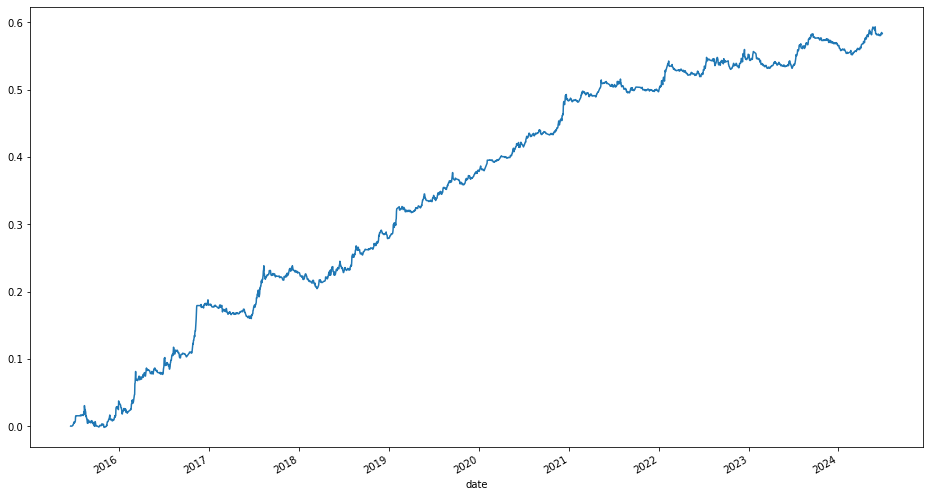

In [5]:
engine.clear_data()
setting = {
    "window": 350,
    "bband_width": 1.5,
}
engine.add_strategy(MACDBBANDStrategy, setting)

engine.run_backtesting()
df = engine.calculate_result()

daily_base = pd.Series(df['net_pnl'] / engine.capital, index=pd.to_datetime(df.index))
daily_base.cumsum().plot(figsize=(16, 9))
calc_sharpe(daily_base)

## Full set

- CODES_SHORT
- Vol exit
- LS imba

### ATR multiplier = 11

In [6]:
setting = {
    "window": 50,
}
engine.add_strategy(MACDBBANDStrategy, setting)


setting = OptimizationSetting()
setting.set_target("sharpe_ratio")
setting.add_parameter("window", 50, 500, 50)
setting.add_parameter("bband_width", 1.5, 2, 0.25)
setting.add_parameter("atr_multiplier", 11)

opt_res = engine.run_bf_optimization(setting, max_workers=10)

2024-06-28 13:22:55.919973	开始执行穷举算法优化
2024-06-28 13:22:55.919973	参数优化空间：30


100%|██████████| 30/30 [08:51<00:00, 17.70s/it]


2024-06-28 13:31:50.599180	穷举算法优化完成，耗时534秒
2024-06-28 13:31:54.728214	参数：{'window': 350, 'bband_width': 1.5, 'atr_multiplier': 11}, 目标：1.6545569295810152
2024-06-28 13:31:54.728214	参数：{'window': 50, 'bband_width': 1.5, 'atr_multiplier': 11}, 目标：1.4595867239927953
2024-06-28 13:31:54.728214	参数：{'window': 250, 'bband_width': 1.5, 'atr_multiplier': 11}, 目标：1.4162272814214354
2024-06-28 13:31:54.728214	参数：{'window': 450, 'bband_width': 1.75, 'atr_multiplier': 11}, 目标：1.3935631187776818
2024-06-28 13:31:54.728214	参数：{'window': 200, 'bband_width': 2.0, 'atr_multiplier': 11}, 目标：1.3895589018723042
2024-06-28 13:31:54.728214	参数：{'window': 350, 'bband_width': 1.75, 'atr_multiplier': 11}, 目标：1.386306497393153
2024-06-28 13:31:54.728214	参数：{'window': 400, 'bband_width': 1.75, 'atr_multiplier': 11}, 目标：1.3830607904029568
2024-06-28 13:31:54.728214	参数：{'window': 400, 'bband_width': 1.5, 'atr_multiplier': 11}, 目标：1.3572717307729527
2024-06-28 13:31:54.728214	参数：{'window': 200, 'bband_width': 1.75, '

In [7]:
sharpe_mat = pd.DataFrame()

for res in opt_res:
    param = res[0]
    sharpe = res[1]
    
    sharpe_mat.loc[param['window'], param['bband_width']] = sharpe
    
sharpe_mat


,1.50,1.75,2.00
350,1.654557,1.386306,1.307874
50,1.459587,1.259623,1.163586
250,1.416227,1.230702,1.310132
450,1.331724,1.393563,1.005144
200,1.223952,1.336479,1.389559
400,1.357272,1.383061,1.128801
100,1.288979,1.126110,0.997982
150,1.181224,1.272974,1.148168
500,1.136147,1.217110,1.157300
300,1.171690,1.202849,1.198186


### ATR multiplier = 13

In [8]:
setting = {
    "window": 50,
}
engine.add_strategy(MACDBBANDStrategy, setting)


setting = OptimizationSetting()
setting.set_target("sharpe_ratio")
setting.add_parameter("window", 50, 500, 50)
setting.add_parameter("bband_width", 1.5, 2, 0.25)
setting.add_parameter("atr_multiplier", 13)

opt_res = engine.run_bf_optimization(setting, max_workers=10)

sharpe_mat = pd.DataFrame()

for res in opt_res:
    param = res[0]
    sharpe = res[1]

    sharpe_mat.loc[param['window'], param['bband_width']] = sharpe

sharpe_mat.sort_index()

2024-06-28 13:33:36.892813	开始执行穷举算法优化
2024-06-28 13:33:36.892813	参数优化空间：30


100%|██████████| 30/30 [08:46<00:00, 17.55s/it]


2024-06-28 13:42:27.229059	穷举算法优化完成，耗时530秒
2024-06-28 13:42:31.192571	参数：{'window': 100, 'bband_width': 1.5, 'atr_multiplier': 13}, 目标：1.5277339340400575
2024-06-28 13:42:31.192571	参数：{'window': 350, 'bband_width': 1.5, 'atr_multiplier': 13}, 目标：1.5101383668903299
2024-06-28 13:42:31.192571	参数：{'window': 200, 'bband_width': 2.0, 'atr_multiplier': 13}, 目标：1.504251309652192
2024-06-28 13:42:31.192571	参数：{'window': 200, 'bband_width': 1.75, 'atr_multiplier': 13}, 目标：1.440904062423533
2024-06-28 13:42:31.192571	参数：{'window': 150, 'bband_width': 1.75, 'atr_multiplier': 13}, 目标：1.3998189407350803
2024-06-28 13:42:31.192571	参数：{'window': 450, 'bband_width': 1.75, 'atr_multiplier': 13}, 目标：1.3963082453180409
2024-06-28 13:42:31.192571	参数：{'window': 450, 'bband_width': 1.5, 'atr_multiplier': 13}, 目标：1.3936022691135765
2024-06-28 13:42:31.192571	参数：{'window': 400, 'bband_width': 1.75, 'atr_multiplier': 13}, 目标：1.3864604447787905
2024-06-28 13:42:31.192571	参数：{'window': 100, 'bband_width': 1.75, 

,1.50,2.00,1.75
50,1.340082,1.239352,1.335583
100,1.527734,1.147006,1.375470
150,1.283021,1.288361,1.399819
200,1.284515,1.504251,1.440904
250,1.319716,1.237466,1.191095
300,1.147005,1.249634,1.289021
350,1.510138,1.258338,1.333270
400,1.306660,1.200506,1.386460
450,1.393602,0.975202,1.396308
500,1.206760,1.148958,1.138176


## LS balance

In [5]:
setting = {
    "window": 50,
}
engine.add_strategy(MACDBBANDStrategy, setting)


setting = OptimizationSetting()
setting.set_target("sharpe_ratio")
setting.add_parameter("window", 50, 500, 50)
setting.add_parameter("bband_width", 1.5, 2, 0.25)
setting.add_parameter("atr_multiplier", 13)
setting.add_parameter("ls_imba", 1)

opt_res = engine.run_bf_optimization(setting, max_workers=10)

sharpe_mat = pd.DataFrame()

for res in opt_res:
    param = res[0]
    sharpe = res[1]

    sharpe_mat.loc[param['window'], param['bband_width']] = sharpe

sharpe_mat.sort_index()

2024-06-28 13:55:15.390178	开始执行穷举算法优化
2024-06-28 13:55:15.390178	参数优化空间：30


100%|██████████| 30/30 [08:34<00:00, 17.16s/it]


2024-06-28 14:03:54.006441	穷举算法优化完成，耗时518秒
2024-06-28 14:03:58.044837	参数：{'window': 200, 'bband_width': 2.0, 'atr_multiplier': 13, 'ls_imba': 1}, 目标：1.477948680602513
2024-06-28 14:03:58.044837	参数：{'window': 350, 'bband_width': 1.5, 'atr_multiplier': 13, 'ls_imba': 1}, 目标：1.3545238797920702
2024-06-28 14:03:58.044837	参数：{'window': 200, 'bband_width': 1.75, 'atr_multiplier': 13, 'ls_imba': 1}, 目标：1.303462404711154
2024-06-28 14:03:58.044837	参数：{'window': 300, 'bband_width': 2.0, 'atr_multiplier': 13, 'ls_imba': 1}, 目标：1.294894175173755
2024-06-28 14:03:58.044837	参数：{'window': 150, 'bband_width': 1.5, 'atr_multiplier': 13, 'ls_imba': 1}, 目标：1.2719217219882897
2024-06-28 14:03:58.044837	参数：{'window': 250, 'bband_width': 2.0, 'atr_multiplier': 13, 'ls_imba': 1}, 目标：1.2272948066972218
2024-06-28 14:03:58.044837	参数：{'window': 150, 'bband_width': 1.75, 'atr_multiplier': 13, 'ls_imba': 1}, 目标：1.2041619376649528
2024-06-28 14:03:58.044837	参数：{'window': 300, 'bband_width': 1.5, 'atr_multiplier':

,2.00,1.50,1.75
50,1.083932,1.090524,1.067301
100,1.159572,1.165506,1.188637
150,1.058137,1.271922,1.204162
200,1.477949,1.179580,1.303462
250,1.227295,1.145845,1.085171
300,1.294894,1.192111,1.181943
350,1.046559,1.354524,1.074944
400,0.802978,1.089987,0.887064
450,0.889659,0.959786,1.008924
500,0.703280,0.936412,0.922516


## CODES_MM

In [6]:
from Pandora.research import CODES_MM

mc = get_mc(CODES_MM)


In [7]:
engine = BacktestingEngine()
engine.contracts = {i.vt_symbol: i for i in mc}

engine.set_parameters(
    vt_symbols=[i.vt_symbol for i in mc],
    interval=Interval.MINUTE_15,
    start=datetime(2015, 1, 1),
    end=datetime(2024, 6, 27),
    rates={
        i.vt_symbol: COMMISSION for i in mc
    },
    slippages={
        i.vt_symbol: 0 for i in mc
    },
    sizes={
        i.vt_symbol: i.size for i in mc
    },
    priceticks={
        i.vt_symbol: i.pricetick for i in mc
    },
    capital=1e8,
)

engine.load_data()



2024-06-28 14:06:42.344199	开始加载历史数据
2024-06-28 14:06:42.352178	AP00.CZCE历史数据加载完成，数据量：23655
2024-06-28 14:06:43.226538	CF00.CZCE历史数据加载完成，数据量：54324
2024-06-28 14:06:43.246484	FG00.CZCE历史数据加载完成，数据量：53294
2024-06-28 14:06:43.269423	MA00.CZCE历史数据加载完成，数据量：54324
2024-06-28 14:06:43.277401	SA00.CZCE历史数据加载完成，数据量：24624
2024-06-28 14:06:44.082766	SR00.CZCE历史数据加载完成，数据量：54324
2024-06-28 14:06:44.101715	TA00.CZCE历史数据加载完成，数据量：54324
2024-06-28 14:06:44.134136	al00.SHFE历史数据加载完成，数据量：69405
2024-06-28 14:06:44.645793	bu00.SHFE历史数据加载完成，数据量：54480
2024-06-28 14:06:45.113051	c00.DCE历史数据加载完成，数据量：43960
2024-06-28 14:06:45.529444	fu00.SHFE历史数据加载完成，数据量：38516
2024-06-28 14:06:45.550388	hc00.SHFE历史数据加载完成，数据量：54480
2024-06-28 14:06:45.569841	i00.DCE历史数据加载完成，数据量：54938
2024-06-28 14:06:45.589788	j00.DCE历史数据加载完成，数据量：54938
2024-06-28 14:06:45.625692	jm00.DCE历史数据加载完成，数据量：54938
2024-06-28 14:06:46.383193	m00.DCE历史数据加载完成，数据量：54938
2024-06-28 14:06:46.409123	ni00.SHFE历史数据加载完成，数据量：67705
2024-06-28 14:06:46.428073	p00.DCE历史数据

In [8]:
setting = {
    "window": 50,
}
engine.add_strategy(MACDBBANDStrategy, setting)


setting = OptimizationSetting()
setting.set_target("sharpe_ratio")
setting.add_parameter("window", 50, 500, 50)
setting.add_parameter("bband_width", 1.5, 2, 0.25)
setting.add_parameter("atr_multiplier", 11)

opt_res = engine.run_bf_optimization(setting, max_workers=8)

2024-06-28 14:06:58.077491	开始执行穷举算法优化
2024-06-28 14:06:58.077491	参数优化空间：30


100%|██████████| 30/30 [12:03<00:00, 24.13s/it]


2024-06-28 14:19:06.049233	穷举算法优化完成，耗时727秒
2024-06-28 14:19:13.878092	参数：{'window': 350, 'bband_width': 1.5, 'atr_multiplier': 11}, 目标：1.5118609359285895
2024-06-28 14:19:13.879090	参数：{'window': 250, 'bband_width': 1.75, 'atr_multiplier': 11}, 目标：1.299231132850395
2024-06-28 14:19:13.879090	参数：{'window': 50, 'bband_width': 1.5, 'atr_multiplier': 11}, 目标：1.2914193622217442
2024-06-28 14:19:13.879090	参数：{'window': 250, 'bband_width': 1.5, 'atr_multiplier': 11}, 目标：1.2880250953683596
2024-06-28 14:19:13.879090	参数：{'window': 200, 'bband_width': 1.5, 'atr_multiplier': 11}, 目标：1.2712647084839712
2024-06-28 14:19:13.879090	参数：{'window': 350, 'bband_width': 2.0, 'atr_multiplier': 11}, 目标：1.2643682498437556
2024-06-28 14:19:13.879090	参数：{'window': 450, 'bband_width': 1.75, 'atr_multiplier': 11}, 目标：1.2285012845448102
2024-06-28 14:19:13.879090	参数：{'window': 50, 'bband_width': 1.75, 'atr_multiplier': 11}, 目标：1.2146656502681035
2024-06-28 14:19:13.879090	参数：{'window': 200, 'bband_width': 2.0, 'at

In [9]:
sharpe_mat = pd.DataFrame()

for res in opt_res:
    param = res[0]
    sharpe = res[1]
    
    sharpe_mat.loc[param['window'], param['bband_width']] = sharpe
    
sharpe_mat


,1.50,1.75,2.00
350,1.511861,1.198608,1.264368
250,1.288025,1.299231,1.184247
50,1.291419,1.214666,1.067633
200,1.271265,1.149787,1.199646
450,1.024814,1.228501,0.862897
300,1.124724,1.067881,1.183105
400,1.146662,1.125745,1.176479
150,1.077968,1.162563,1.054383
100,1.091876,0.970494,0.830469
500,1.041636,0.718780,1.091552
